In [ ]:
import tools
import pandas as pd 
import numpy as np 
import os
from matplotlib.patches import Polygon
from scipy.spatial import ConvexHull
from matplotlib.animation import FuncAnimation, FFMpegWriter
from IPython.display import HTML

In [100]:
def compute_convex_area(row, x_cols, y_cols):
    points = [
        [row[x], row[y]]
        for x, y in zip(x_cols, y_cols)
        if pd.notna(row[x]) and pd.notna(row[y])
    ]

    if len(points) < 3:
        return np.nan

    try:
        hull = ConvexHull(points)
        return hull.volume  # No 2D, volume é a área da casca convexa
    except Exception as e:
        return np.nan

In [101]:
def create_area(df,text=None):
    if text: 
        print(f'Calculating Area - Convex Hull | {text}')
    else:
        print('Calculating Area - Convex Hull')

    x_cols = [col for col in df.columns if col.endswith('_x')]
    y_cols = [col for col in df.columns if col.endswith('_y')]

    x_cols.sort()
    y_cols.sort()

    # area_func = partial(compute_convex_area, x_cols=x_cols, y_cols=y_cols)
    # df['area'] = df.apply(area_func, axis=1)
    df['area'] = df.apply(lambda row: compute_convex_area(row, x_cols, y_cols), axis=1)
    return df.dropna().reset_index(drop=True)

In [102]:
def create_area_video(df_b, df_o, sport, variable, save=True):
    print(f'Creating video | {sport.capitalize()} {variable.capitalize()}')

    blue_ids = tools.get_team_list(sport, 'blue')     
    orange_ids = tools.get_team_list(sport, 'orange')

    # Colunas dinâmicas
    blue_cols = [f'{pid}_{axis}' for pid in blue_ids for axis in ['x', 'y']]
    orange_cols = [f'{pid}_{axis}' for pid in orange_ids for axis in ['x', 'y']]

    # Cria figura e elementos
    fig, ax = tools.draw_field_court(sport)
    scat_blue = ax.scatter([], [], s=50, color='blue')
    scat_orange = ax.scatter([], [], s=50, color='orange')

    poly_blue = Polygon([[0, 0]], closed=True, color='blue', alpha=0.4)
    poly_orange = Polygon([[0, 0]], closed=True, color='orange', alpha=0.5)
    ax.add_patch(poly_blue)
    ax.add_patch(poly_orange)

    area_text_blue = ax.text(0.05, 0.94, '', transform=ax.transAxes, fontsize=12, color='black')
    area_text_orange = ax.text(0.30, 0.94, '', transform=ax.transAxes, fontsize=12, color='black')

    def get_hull_coords(coords):
        if len(coords) < 3:
            return [], float('nan')
        try:
            hull = ConvexHull(coords)
            hull_pts = [coords[v] for v in hull.vertices]
            area = hull.volume
            return hull_pts, area
        except:
            return [], float('nan')

    def update(frame):
        # Coleta posições
        blue_coords = list(zip(df_b.loc[frame, blue_cols[::2]],
                               df_b.loc[frame, blue_cols[1::2]]))
        orange_coords = list(zip(df_o.loc[frame, orange_cols[::2]],
                                 df_o.loc[frame, orange_cols[1::2]]))

        # Atualiza posições dos jogadores
        scat_blue.set_offsets(blue_coords)
        scat_orange.set_offsets(orange_coords)

        # Calcula e atualiza convex hulls e áreas
        blue_hull, blue_area = get_hull_coords(blue_coords)
        orange_hull, orange_area = get_hull_coords(orange_coords)

        poly_blue.set_xy(blue_hull + [blue_hull[0]] if blue_hull else [])
        poly_orange.set_xy(orange_hull + [orange_hull[0]] if orange_hull else [])

        area_text_blue.set_text(f'Blue: {blue_area:.2f} m²')
        area_text_orange.set_text(f'Orange: {orange_area:.2f} m²')

        return scat_blue, scat_orange, poly_blue, poly_orange, area_text_blue, area_text_orange

    min_frames = min(len(df_b), len(df_o))

    # Criação da animação
    anim = FuncAnimation(fig, update, frames=range(0, min_frames, 2), interval=40, blit=True)
    writer = FFMpegWriter(fps=30)

    if save == True:
        folder_dir = f'results/{variable}/{sport}/'
        print(f'    Saving video: {folder_dir}{sport}.mp4')
        os.makedirs(folder_dir, exist_ok=True)
        anim.save(f'{folder_dir}{sport}.mp4', writer=writer)
    return anim

In [103]:
def calculate_area(sport, variable='area', save=True):
    df_b, df_o = tools.load_data(sport)
    df_b = create_area(df_b, f'{sport.capitalize()} - Blue')
    df_o = create_area(df_o, f'{sport.capitalize()} - Orange')

    anim = create_area_video(df_b, df_o, sport, 'area', save=True)
    if save == True:
        folder_dir = f'results/{variable}/{sport}/'
        print(f'    Saving data: {folder_dir}{sport}_blue.csv')
        df_b.to_csv(f'{folder_dir}{sport}_blue.csv',index=False)
        print(f'    Saving data: {folder_dir}{sport}_orange.csv')
        df_o.to_csv(f'{folder_dir}{sport}_orange.csv',index=False)
    return df_b, df_o, anim

Loading XY data: Volleyball
Calculating Area - Convex Hull | Volleyball - Blue
Calculating Area - Convex Hull | Volleyball - Orange
Creating video | Volleyball Area
    Saving video: results/area/volleyball/volleyball.mp4
    Saving data: results/area/volleyball/volleyball_blue.csv
    Saving data: results/area/volleyball/volleyball_orange.csv


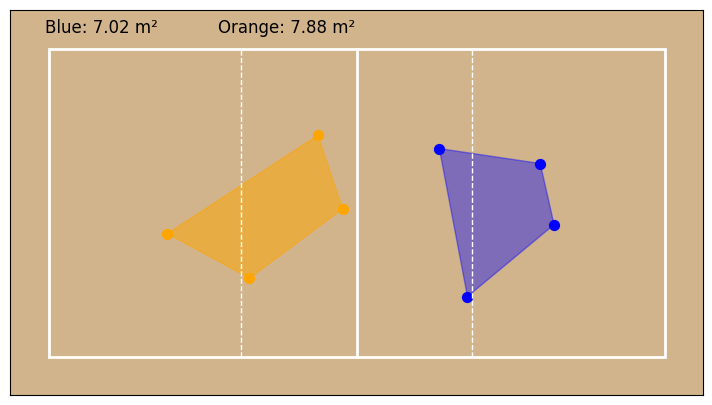

In [106]:
sport = 'volleyball' #soccer, basketball, volleyball
df_b, df_o, anim = calculate_area(sport)

In [ ]:
# Create video on .ipynb
HTML(anim.to_html5_video()) 